# MountainCarContinuous

In [1]:
import gymnasium as gym

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

-34.333349144111274


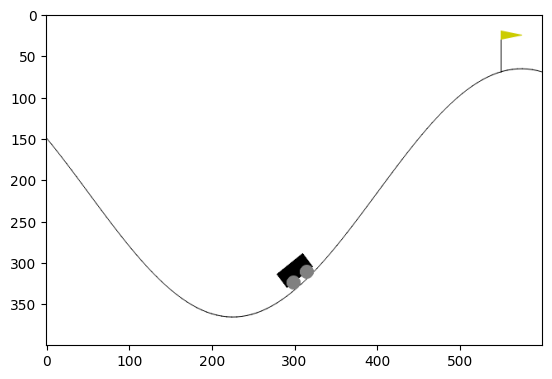

In [2]:
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
observation, info = env.reset()
img = plt.imshow(env.render())

score = 0.0
while True:
    # display
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

    action = env.action_space.sample()  # this is where you would insert your policy
    ob, r, done, oob, info = env.step(action)
    score += r

    if done or oob:
        break

print(score)
env.close()

# Pendulum

-852.1462174026603


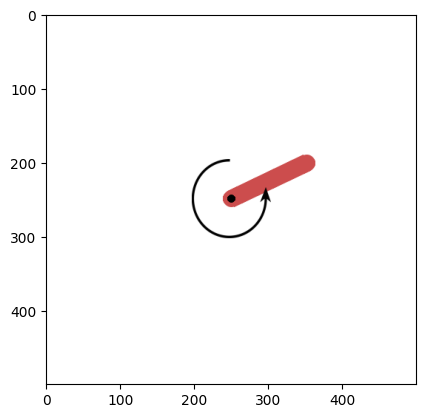

In [3]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")
observation, info = env.reset()
img = plt.imshow(env.render())

score = 0.0
while True:
    # display
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

    action = env.action_space.sample()  # this is where you would insert your policy
    ob, r, done, oob, info = env.step(action)
    score += r

    if done or oob:
        break

print(score)
env.close()

# Deep Deterministic Policy Gradient

In [4]:
import copy
import collections
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gymnasium as gym

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import tqdm

In [5]:
# Replay buffer
class ReplayBuffer():
    def __init__(self, maxlen=100000):
        self.buffer = collections.deque(maxlen=maxlen)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n=128):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(np.array(s_lst), dtype=torch.float), \
               torch.tensor(np.array(a_lst), dtype=torch.float), \
               torch.tensor(np.array(r_lst), dtype=torch.float), \
               torch.tensor(np.array(s_prime_lst), dtype=torch.float), \
               torch.tensor(np.array(done_mask_lst), dtype=torch.float)

    def size(self):
        return len(self.buffer)

In [6]:
class OUNoise:
    """
    Ornstein-Uhlenbeck process.
    https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py#L132C1-L152C26
    """

    def __init__(self, size, seed=1234, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([(random.random() * 2 - 1) for i in range(len(x))]) # Noise: a = μ(s) + t
        self.state = x + dx
        return self.state

In [7]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden1 = nn.Linear(2, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)

    def forward(self, state):
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh()

        return action

In [8]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden1 = nn.Linear(2 + 1, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)

        return value

In [9]:
class DDPG:
    def __init__(self, tau=5e-3):
        self.actor = Actor() # Behavior Network
        self.actor_target = Actor() # Target Network
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic = Critic() # Behavior Network
        self.critic_target = Critic() # Target Network
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.noise = OUNoise(1)

        self.tau = tau
        
    # DQN: 일정 주기마다 Behavior Network의 weights를 Target Netowrk으로 복사
    # DDQN: 매번 Behavior Network의 weights를 Target Netowrk으로 업데이트
    def soft_update(self):
        # ϕ̂ ← τϕ + (1 − τ)ϕ̂
        for t_param, l_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            t_param.data.copy_(self.tau * l_param.data + (1.0 - self.tau) * t_param.data)

        # θ' ← τθ + (1 − τ)̂θ'
        for t_param, l_param in zip(self.critic_target.parameters(), self.critic.parameters()):
            t_param.data.copy_(self.tau * l_param.data + (1.0 - self.tau) * t_param.data)
    
    def select_action(self, state, noise=True):
        selected_action = self.actor(torch.from_numpy(state).float()).detach().numpy()
        if noise:
            noise = self.noise.sample()
            selected_action = np.clip(selected_action + noise, -1.0, 1.0)
        return selected_action

In [10]:
ddpg = DDPG()
memory = ReplayBuffer()

In [11]:
act_optim = optim.Adam(ddpg.actor.parameters(), lr=3e-4)
cri_optim = optim.Adam(ddpg.critic.parameters(), lr=1e-3)

In [12]:
def train(ddpg, memory, act_optim, cri_optim, gamma=0.99):
    s, a, r, s_prime, done_mask = memory.sample()

    a_prime = ddpg.actor_target(s_prime)
    q_prime = ddpg.critic_target(s_prime, a_prime)
    q_true = r + gamma * q_prime.detach() * done_mask

    # train critic
    q_pred = ddpg.critic(s, a)
    cir_loss = F.mse_loss(q_pred, q_true)
    cri_optim.zero_grad()
    cir_loss.backward()
    cri_optim.step()

    # train actor
    act_loss = -ddpg.critic(s, ddpg.actor(s)).mean()
    act_optim.zero_grad()
    act_loss.backward()
    act_optim.step()

    ddpg.soft_update()

In [13]:
score = 0.0
max_score = -10000.0

env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
s, _ = env.reset()

p_bar = tqdm.trange(100000)
for i in p_bar:
    if i < 9999: # 일정 주기 랜덤 샘플
        a = env.action_space.sample()
    else:
        a = ddpg.select_action(s)
    s_prime, r, done, oob, _ = env.step(a)
    done_mask = 0.0 if (done or oob) else 1.0
    memory.put((s, a, r/100.0, s_prime, done_mask))

    s = s_prime
    score += r

    if done or oob:
        s, _ = env.reset()
        p_bar.set_description(f'max: {max_score:.5f}, curr: {score:5f}')
        if score >= max_score: # 성능 개선이 있었으면
            torch.save(ddpg.actor.state_dict(), 'ddpg_actor.pth')
            max_score = score
        score = 0.0

    if i >= 9999:
        train(ddpg, memory, act_optim, cri_optim)

p_bar.close()


ax: 95.74688, curr: 93.692868: 100%|█████████████████████████████████████████| 100000/100000 [10:32<00:00, 158.17it/s]

In [14]:
ddpg = DDPG()
ddpg.actor.load_state_dict(torch.load('ddpg_actor.pth'))

<All keys matched successfully>

97.52830648075495


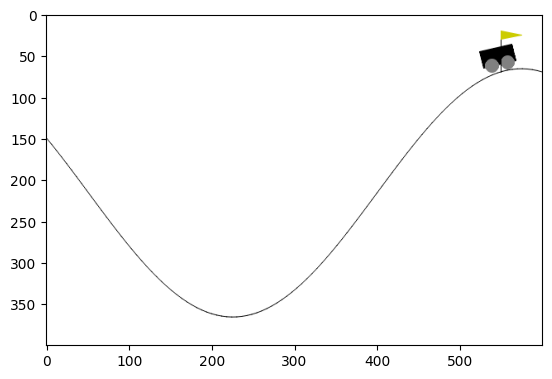

In [17]:
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
s, _ = env.reset()
img = plt.imshow(env.render())

score = 0.0
while True:
    # display
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    a = ddpg.select_action(s, noise=False)  # noise 없음
    s_prime, r, done, oob, info = env.step(a)
    s = s_prime
    
    score += r
    if done or oob:
        break

env.close()
print(score)

In [16]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action